# Tresholding grayscale images by normalized graph cuts 

Code was created with accordance to article by Wenbing Tao, Hai Jin, Yimin Zhang, Liman Liu, and Desheng Wang.
<br>
Link: https://ieeexplore.ieee.org/document/4604825

Idea of processing: 
<br>
1) Open any image as grayscale to get only one value for intensity
<br>
2) Create undirected weighted graph G = (V, E), where weights corresponds to similiarity between two pixels
<br>
3) Create 256x256 matrix M, where m_ij represents sum of weights of ,,cut" between pixels with intenisty i and pixels j.
<br>
4) Search for optimal treshold using normalized cuts on matrix M (faster method than working with graph!)
<br>
4) Treshold image 

In [24]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from datetime import timedelta
from skimage import io, filters, measure
from scipy import ndimage

In [30]:
# Graph does not need to be directed - we work directly only on ,,cut matrix"
# arr is array of image in grayscale (width x height) - it's elements are intenisities of pixels
# I - sensivity of weights for intensity changes
# X - sensivity of weights for spatial location between nodes


# defining norm in R^2
def norm(x1, y1, x2, y2):
    norm = math.sqrt((x1-x2) ** 2 + (y1-y2) ** 2)
    return norm

# defining function assigning weight to an edge
def set_capacity(arr, x1, y1, x2, y2, I, X):
    capacity = np.exp( - ((abs(arr[x1][y1] - arr[x2][y2]) / I + norm(x1, y1, x2, y2) / X )) )
    return capacity

# creating cut matrix for an image

def create_cut_matrix(arr, I, X):
    M = np.zeros((256,256))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i > 0:
                capacity = set_capacity(arr,i,j,i-1,j,I,X)
                M[arr[i-1][j]][arr[i][j]] += capacity
                M[arr[i][j]][arr[i-1][j]] += capacity
                if j > 0:
                    capacity = set_capacity(arr,i-1,j-1,i,j,I,X)
                    M[arr[i-1][j-1]][arr[i][j]] += capacity
                    M[arr[i][j]][arr[i-1][j-1]] += capacity
                if j < arr.shape[0] - 1:
                    capacity = set_capacity(arr,i,j,i-1,j+1,I,X)
                    M[arr[i-1][j+1]][arr[i][j]] += capacity
                    M[arr[i][j]][arr[i-1][j+1]] += capacity
            if j > 0:
                capacity = set_capacity(arr,i,j-1,i,j,I,X)
                M[arr[i][j-1]][arr[i][j]] += capacity
                M[arr[i][j]][arr[i][j-1]] += capacity     
    return M

# defining function that returns optimal cut for given cut matrix M, threshold of cut t and minimal cut

def get_NCut(t, M, NCut_min):
    cutAB = 0                                # cut with sets A and B
    assoAA = 0                               # sum of weights between pixels in A
    assoBB = 0                               # sum of weights between pixels in B
    for i in range(0,t+1):
        for j in range(t+1,256):
            cutAB += M[i][j]
    for i in range(0,t+1):
        for j in range(i,t+1):
            assoAA += M[i][j]
    for i in range(t+1,256):
        for j in range(i,256):
            assoBB += M[i][j]
    A = assoAA + cutAB
    B = assoBB + cutAB
    if A != 0 and B != 0:
        NCutAB = (cutAB / A) + (cutAB / B)    # get normalized cut
    else:
        NCutAB = NCut_min
    return NCutAB

# get optimal treshold that results in minimal normalized cut for given ,,cut matrix" M 
def get_treshold(M):
    # initialization
    t = 0
    t_min = 0
    NCut_min = 2
    # search for best treshold and cut
    while t <= 255:
        NCutAB = get_NCut(t, M, NCut_min)
        if NCutAB < NCut_min:
            NCut_min = NCutAB
            t_min = t
        t += 1
    return NCut_min, t_min

# get segmentation by usage of obtained treshold
def treshold_image(arr, treshold):
    result = arr
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] > treshold :
                result[i][j] = 0
            else:
                result[i][j] = 1
    return result

In [29]:
# image is unopened picture, I and X need to be specified by user (possible automatic detection ??)

def pipeline(image, I, X):
    
    im = Image.open(image).convert('L')
    
    im_arr = np.array(im, dtype='int64')    # int for possibility to iterate!
    
    # thresholding picture by cut matrix method
    
    M = create_cut_matrix(im_arr, I, X)
    
    N, T = get_treshold(M)
    
    result = treshold_image(im_arr, T)
    
    # fill the holes in blood cells for better counting
    
    hole_value = filters.threshold_mean(result)
    
    result = ndimage.binary_fill_holes(result > hole_value)
    
    labels = measure.label(result)
    
    # number of cells is equal to maximal label
    
    counter = labels.max()
    
    return result, counter
        

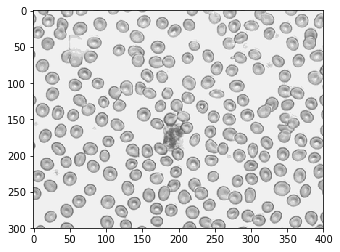

In [22]:
im = Image.open('red_blood_cells.png').convert('L')
plt.imshow(im)

The number of blood cells in picture equals 198.
Time of calcualtions: 0:00:15.531000


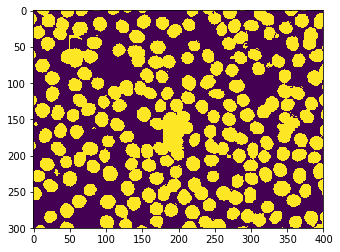

In [28]:
start_time = time.monotonic()
result, counter = pipeline('red_blood_cells.png', 625, 4)
plt.imshow(result)
print('The number of blood cells in picture equals {}.'.format(counter))
end_time = time.monotonic()
print('Time of calcualtions: {}'.format(timedelta(seconds = end_time - start_time)))